In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
mpl.rcParams["figure.frameon"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.labelweight"] = "normal"

sns.set_palette("colorblind")

In [3]:
BASE_PATH = Path("./data/")
IMGS_PATH = BASE_PATH / "mimic-cxr-jpg-2.1.0/"
CXR24_PATH = Path("data/cxr-lt-iccv-workshop-cvamd/2.0.0/cxr-lt-2024/")
TRAIN_LABELS_FILE = CXR24_PATH / "train_labeled.csv"
train_df = pd.read_csv(TRAIN_LABELS_FILE)
total_rows = len(train_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258871 entries, 0 to 258870
Data columns (total 46 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   dicom_id                      258871 non-null  object
 1   subject_id                    258871 non-null  int64 
 2   study_id                      258871 non-null  object
 3   ViewPosition                  248137 non-null  object
 4   ViewCodeSequence_CodeMeaning  247649 non-null  object
 5   fpath                         258871 non-null  object
 6   Adenopathy                    258871 non-null  int64 
 7   Atelectasis                   258871 non-null  int64 
 8   Azygos Lobe                   258871 non-null  int64 
 9   Calcification of the Aorta    258871 non-null  int64 
 10  Cardiomegaly                  258871 non-null  int64 
 11  Clavicle Fracture             258871 non-null  int64 
 12  Consolidation                 258871 non-null  int64 
 13 

In [4]:
patients = train_df["subject_id"].unique()
print(f"Total number of patients: {len(patients)}")

Total number of patients: 45480


108


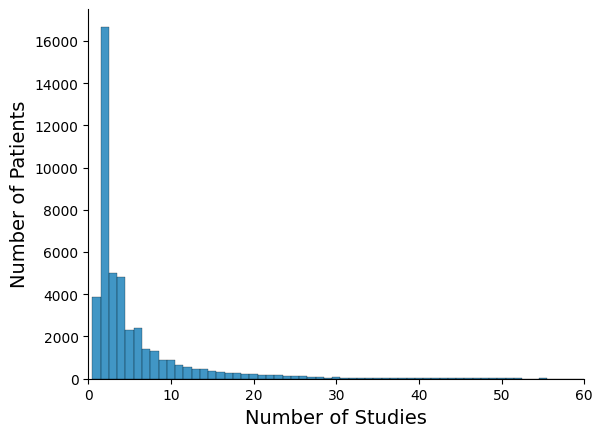

In [5]:
patient_studies = train_df.groupby("subject_id")["study_id"].count()
print(patient_studies.nunique())

# plt.figure(figsize=(8, 10))
ax = sns.histplot(patient_studies, discrete=True)
plt.xlim(0, 60)
plt.xlabel("Number of Studies")
plt.ylabel("Number of Patients")
plt.show()

ViewPosition
AP                100024
PA                 66470
LATERAL            57546
LL                 24080
LAO                    3
RAO                    3
PA LLD                 3
XTABLE LATERAL         2
AP AXIAL               2
AP LLD                 1
SWIMMERS               1
AP RLD                 1
PA RLD                 1
Name: count, dtype: int64
      View  Counts
0  Frontal  166508
1  Lateral   81633
2  Missing   10734


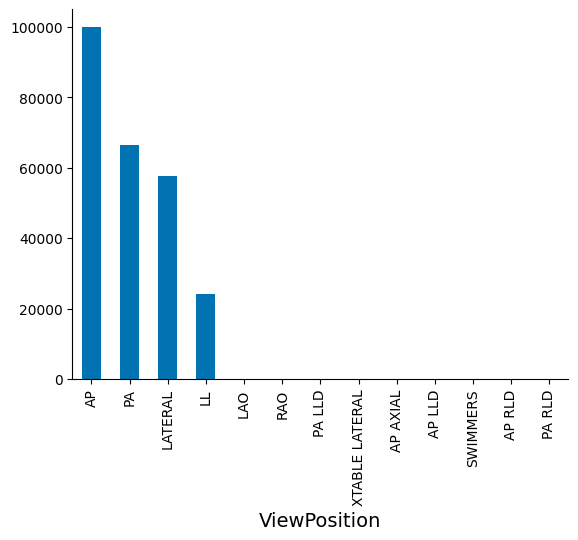

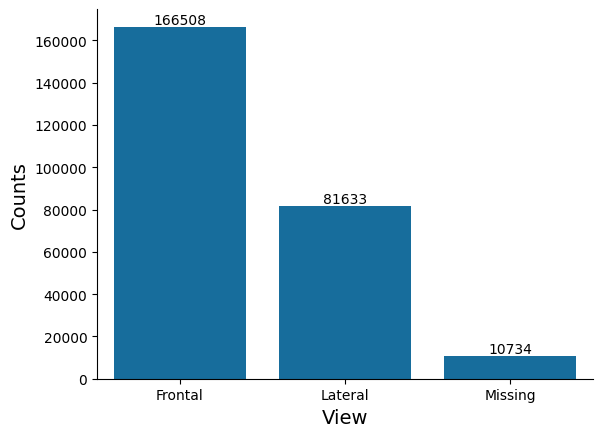

In [6]:
print(train_df["ViewPosition"].value_counts())
FRONTAL_CODES = [
    "AP",
    "PA",
    "LAO",
    "RAO",
    "AP AXIAL",
    "AP LLD",
    "PA LLD",
    "AP RLD",
    "PA RLD",
]
LATERAL_CODES = ["LATERAL", "LL", "XTABLE LATERAL", "SWIMMERS"]

view_count = pd.DataFrame(
    {
        "View": ["Frontal", "Lateral", "Missing"],
        "Counts": [
            train_df["ViewPosition"][
                train_df["ViewPosition"].str.contains("|".join(FRONTAL_CODES), na=False)
            ].count(),
            train_df["ViewPosition"][
                train_df["ViewPosition"].str.contains("|".join(LATERAL_CODES), na=False)
            ].count(),
            train_df["ViewPosition"].isna().sum(),
        ],
    }
)
print(view_count)
train_df["ViewPosition"].value_counts().plot(kind="bar")
plt.show()

# plt.figure(figsize=(5, 5))
ax = sns.barplot(
    x="View",
    y="Counts",
    data=view_count,
    errorbar=None,
)
ax.bar_label(ax.containers[0], fmt="%d")
plt.show()


In [7]:
view_codes = train_df["ViewPosition"].dropna().unique()
print(f"All view codes: {view_codes}")

n_view_code_meaning_missing = train_df["ViewCodeSequence_CodeMeaning"].isna().sum()
n_view_code_missing = train_df["ViewPosition"].isna().sum()
print(f"Number of missing view codes: {n_view_code_missing}")
print(
    f"Number of view codes with missing description: {n_view_code_meaning_missing - n_view_code_missing}"
)


codes_missing_desc = (
    train_df["ViewPosition"][train_df["ViewCodeSequence_CodeMeaning"].isna()]
    .dropna()
    .unique()
)
print(f"View codes with missing description: {codes_missing_desc}")

assert len(view_codes) == len(FRONTAL_CODES) + len(LATERAL_CODES), (
    f"Incomplete view codes set: {FRONTAL_CODES + LATERAL_CODES} vs {view_codes}"
)
FRONTAL_CAT, LATERAL_CAT = "Frontal", "Lateral"
view_col = np.where(
    train_df["ViewPosition"].str.contains("|".join(FRONTAL_CODES), na=False),
    FRONTAL_CAT,
    np.where(
        train_df["ViewPosition"].str.contains("|".join(LATERAL_CODES), na=False),
        LATERAL_CAT,
        "Unknown",
    ),
)
train_df.insert(
    loc=train_df.columns.get_loc("ViewCodeSequence_CodeMeaning") + 1,
    column="View",
    value=view_col,
)
train_df.head()

All view codes: ['PA' 'LATERAL' 'AP' 'LL' 'LAO' 'RAO' 'AP AXIAL' 'SWIMMERS' 'AP LLD'
 'XTABLE LATERAL' 'PA LLD' 'AP RLD' 'PA RLD']
Number of missing view codes: 10734
Number of view codes with missing description: 488
View codes with missing description: ['AP' 'LL' 'PA' 'PA LLD' 'PA RLD']


,dicom_id,subject_id,study_id,ViewPosition,ViewCodeSequence_CodeMeaning,View,fpath,Adenopathy,Atelectasis,Azygos Lobe,...,Pneumoperitoneum,Pneumothorax,Pulmonary Embolism,Pulmonary Hypertension,Rib Fracture,Round(ed) Atelectasis,Subcutaneous Emphysema,Support Devices,Tortuous Aorta,Tuberculosis
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,s50414267,PA,postero-anterior,Frontal,files/p10/p10000032/s50414267/02aa804e-bde0afd...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,s50414267,LATERAL,lateral,Lateral,files/p10/p10000032/s50414267/174413ec-4ec4c1f...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,s53189527,PA,postero-anterior,Frontal,files/p10/p10000032/s53189527/2a2277a9-b0ded15...,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,s53189527,LATERAL,lateral,Lateral,files/p10/p10000032/s53189527/e084de3b-be89b11...,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,s53911762,AP,antero-posterior,Frontal,files/p10/p10000032/s53911762/68b5c4b1-227d048...,0,0,0,...,0,0,0,0,1,0,0,0,0,0


                            Count freq_class
Lobar Atelectasis             129       Tail
Clavicle Fracture             168       Tail
Round(ed) Atelectasis         172       Tail
Azygos Lobe                   199       Tail
Pneumoperitoneum              516       Tail
Pleural Other                 616       Tail
Hydropneumothorax             646       Tail
Pneumomediastinum             704       Tail
Infarction                    727       Tail
Kyphosis                      778       Tail
Pulmonary Hypertension        903       Tail
Fibrosis                     1169       Tail
Pulmonary Embolism           1631       Tail
Subcutaneous Emphysema       2046       Tail
Tuberculosis                 2078       Tail
Lung Lesion                  2338       Tail
Fissure                      2803     Medium
Granuloma                    2965     Medium
Pleural Thickening           3272     Medium
Tortuous Aorta               3336     Medium
Adenopathy                   3409     Medium
Emphysema 

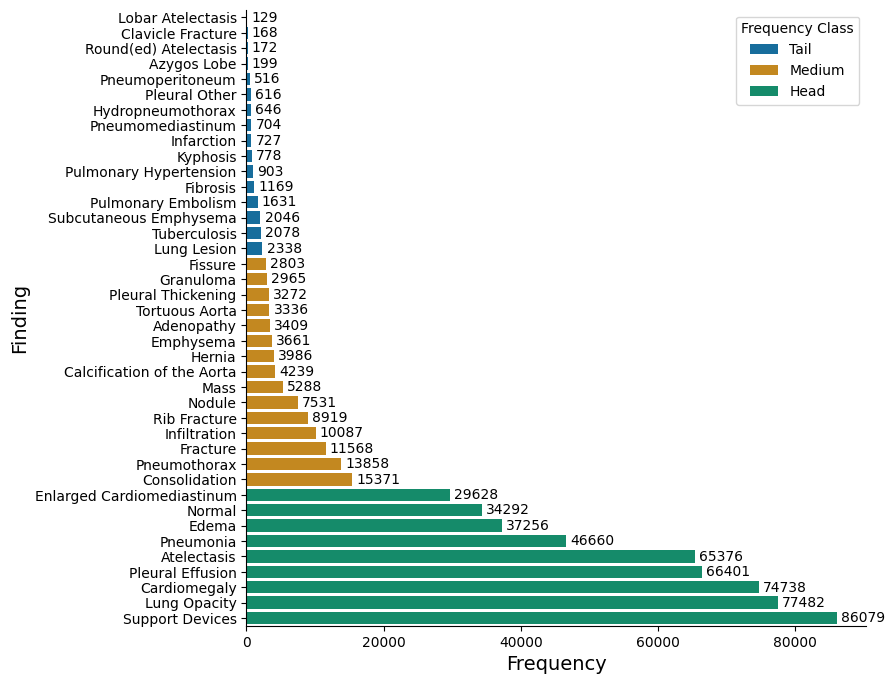

In [8]:
label_counts = pd.DataFrame(train_df.iloc[:, 7:].sum(axis=0).sort_values())
label_counts.columns = ["Count"]
freq_class_bins = [0, 0.01 * total_rows, 0.1 * total_rows, 1.0 * total_rows]
label_counts["freq_class"] = pd.cut(
    label_counts["Count"],
    bins=freq_class_bins,
    labels=["Tail", "Medium", "Head"],
    right=False,
    ordered=True,
)
print(label_counts)
print(len(label_counts))
plt.figure(figsize=(8, 8))
ax = sns.barplot(
    y=label_counts.index,
    x="Count",
    data=label_counts,
    hue="freq_class",
    orient="h",
    errorbar=None,
)
ax.set(xlabel="Frequency", ylabel="Finding")
ax.legend(title="Frequency Class", loc="upper right")

for idx, container in enumerate(ax.containers):
    ax.bar_label(container, fmt="%d", label_type="edge", padding=3)

plt.show()

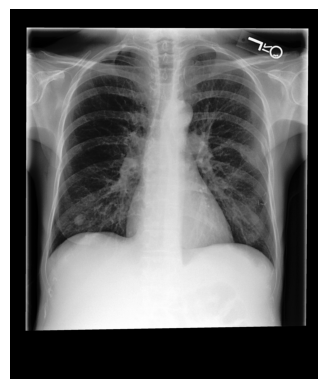

In [9]:
from PIL import Image

file_paths = train_df["fpath"]
first_img = Image.open(IMGS_PATH / file_paths[0])
plt.imshow(first_img, cmap="gray")
plt.axis("off")
plt.show()

data/mimic-cxr-jpg-2.1.0/files/p14/p14306557/s57370900/79db9be0-1a40c0b4-78171b56-63d7969a-8aa661b0.jpg
(2544, 3056)


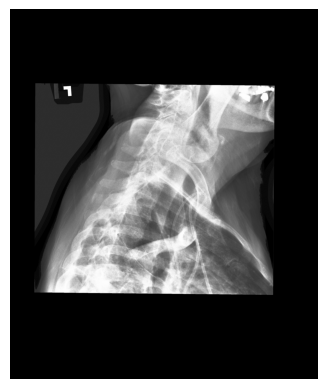

In [10]:
path = IMGS_PATH / train_df["fpath"][train_df["ViewPosition"] == "SWIMMERS"].values[0]
print(path)
swimmers_img = Image.open(path)
print(swimmers_img.size)
plt.imshow(swimmers_img, cmap="gray")
plt.axis("off")
plt.show()

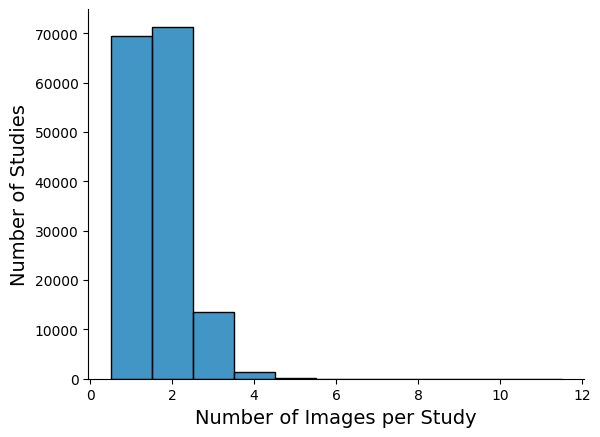

In [11]:
study_counts = train_df.groupby("study_id")["fpath"].count()

sns.histplot(study_counts, discrete=True)
plt.xlabel("Number of Images per Study")
plt.ylabel("Number of Studies")
# plt.title("Distribution of Images per Study")
plt.show()

2


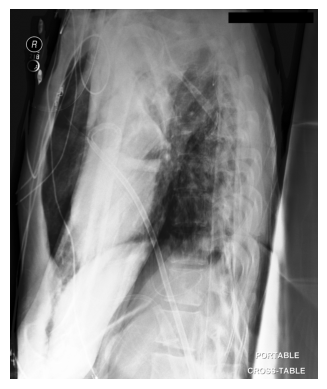

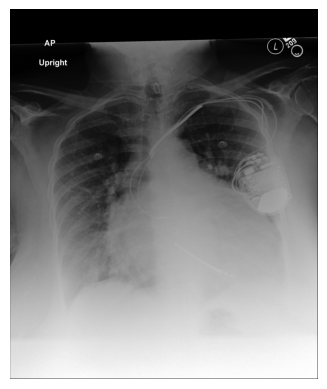

In [12]:
view = "XTABLE LATERAL"
img_paths = train_df["fpath"][train_df["ViewPosition"] ==  view].values
print(len(img_paths))
for img_path in img_paths:
    plt.imshow(Image.open(IMGS_PATH / img_path), cmap="gray")
    plt.axis("off")
    plt.show()